In [23]:
%load_ext autoreload
%autoreload 2
from torch.optim import Adam
from dataloader import TrashNetDataset
from torch.utils.data.dataset import random_split
from matplotlib import pyplot as plt
# from torchvision.models.densenet import densenet121
from torchvision.models.resnet import resnet18
from training_utils import *
import torch
import os

torch.set_num_threads(12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parsing the Training Data

In [2]:
trashset = TrashNetDataset("trashnet/data/dataset-resized")

Splitting the data

In [6]:
valsize = int(len(trashset) * 0.1)
trainsize = int(len(trashset) * 0.8)
testsize = len(trashset) - valsize - trainsize
train_dataset, val_dataset, test_dataset = random_split(trashset, [trainsize, valsize, testsize])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)

Visualizing some samples

x,y = next(iter(train_dataloader))
for ix in range(len(x)):
    plt.axis("off")
    plt.imshow(x[ix])
    plt.title(f"Label: {CLASSES[y[ix].item()]}")
    plt.show()

Initializing the model and optomizer

In [30]:
model = resnet18(pretrained=True)
# DenseNet
# model.classifier = torch.nn.Linear(model.classifier.in_features, len(CLASSES), bias=True)
# for elem in model.features:
#     elem.requires_grad = False
# ResNet
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, len(CLASSES), bias=True)
model.fc.requires_grad = True
model.device = 'cpu'
if torch.cuda.is_available():
    model.device = 'cuda'
model = model.to(model.device)
opt = Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()


total_loss = []
total_acc = []
num_epochs = 0
epochs_per_run = 1

Training the model & Fine Tuning

In [35]:
opt = Adam(model.parameters(), lr=0.00001)

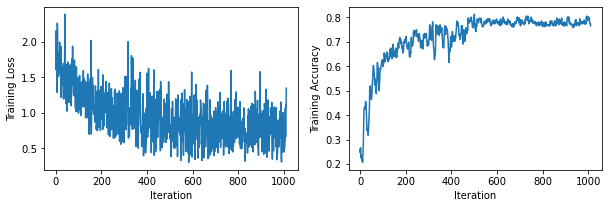

In [36]:
num_epochs += epochs_per_run
losses, acc = train_model(model, train_dataloader, val_dataloader, opt, epochs_per_run)
total_loss += losses
total_acc += acc

fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(total_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(total_acc)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

Saving the weights

In [38]:
if not os.path.isdir("models"):
    os.mkdir("models")
torch.save(model.state_dict(), "models/" + model.__class__.__name__ + ".checkpoint")

